In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from tqdm import tqdm

# Definition of TES algorithm

In [2]:
class HoltWinters:
    def __init__(self, alpha, beta, gamma,dampening, season_length,additive=False):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.dampening = dampening
        self.season_length = season_length
        self.additive = additive
    
    def fit_predict(self,Y, h):
        n = len(Y)
        L = np.zeros(n) # level array
        T = np.zeros(n) # trend array
        S = np.zeros(n) # seasonal array
        F = np.zeros(h) # forecast array

        # Initialize level, trend, and seasonal components
        L[0] = np.mean(Y[:self.season_length])
        T[0] = (np.mean(Y[self.season_length:2*self.season_length]) - L[0]) / self.season_length
        for i in range(self.season_length):
            S[i] = Y[i] / L[0]

        # Holt-Winters equations
        for t in range(self.season_length, n):
            if self.additive:
                L[t] = self.alpha * (Y[t] - S[t - self.season_length]) + (1 - self.alpha) * (L[t - 1] + self.dampening * T[t - 1])
                T[t] = self.beta * (L[t] - L[t - 1]) + (1 - self.beta) * self.dampening * T[t - 1]
                S[t] = self.gamma * (Y[t] - L[t]) + (1 - self.gamma) * S[t - self.season_length]
            else:    
                L[t] = self.alpha * (Y[t] / S[t - self.season_length]) + (1 - self.alpha) * (L[t - 1] + self.dampening * T[t - 1])
                T[t] = self.beta * (L[t] - L[t - 1]) + (1 - self.beta) * self.dampening * T[t - 1]
                S[t] = self.gamma * (Y[t] / L[t]) + (1 - self.gamma) * S[t - self.season_length]
            
        # Forecasting
        for t in range(h):
            if self.additive:
                F[t] = L[n - 1] + (t + 1) * T[-1] + S[n - self.season_length + t%self.season_length]
            else:
                F[t] = (L[n - 1] + (t + 1) * T[-1]) * S[n - self.season_length + t%self.season_length]  
        return F  

# Loading and splitting data

In [3]:
sales_data = pd.read_csv("data/train.csv")
sales_data

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [4]:
print("The stores in the datasets are:\n", sales_data['Store'].sort_values().unique())
print("\nThe departments in the datasets are:\n", sales_data['Dept'].sort_values().unique())

The stores in the datasets are:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]

The departments in the datasets are:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 54 55 56 58 59 60 65 67 71 72 74 77 78 79 80 81 82 83 85 87 90
 91 92 93 94 95 96 97 98 99]


In [5]:
# lets look at the amount of data for each store-department combination
counts_df = sales_data.groupby(['Store','Dept']).size().reset_index(name='Count')
counts_df

,Store,Dept,Count
0,1,1,143
1,1,2,143
2,1,3,143
3,1,4,143
4,1,5,143
...,...,...,...
3326,45,94,134
3327,45,95,143
3328,45,96,2
3329,45,97,143


For most of the combinations we have a complete dataset, however there are some exceptions for each store. Lets check the statistics for each store and compare

In [6]:
# statistics for each Store
counts_df.groupby('Store')['Count'].agg(['min','max','mean','median','std'])

,min,max,mean,median,std
Store,,,,,
1,3,143,133.038961,143.0,31.665788
2,2,143,131.256410,143.0,35.319483
3,1,143,125.500000,143.0,41.834011
4,1,143,131.692308,143.0,35.606547
5,1,143,124.986111,143.0,40.880621
6,2,143,132.610390,143.0,33.121052
7,1,143,128.447368,143.0,35.823045
8,3,143,130.197368,143.0,38.261563
9,2,143,121.465753,143.0,45.555547


We can see that some of the series have a very limited amount of data. In order to perform TES we would need to have at least 52 weeks of data for the initialization and 4 weeks for forecasting. Lets see which store has the least amount of departments we can drop.

In [7]:
counts_df[counts_df['Count'] >= 56].groupby('Store')['Count'].count().sort_values(ascending=False).head(5)

Store
13    74
10    73
34    73
2     72
6     72
Name: Count, dtype: int64

We'll use data only for store 13 moving forward. We'll also drop the departments with less than 56 data points.

In [8]:
departments_to_use = counts_df[(counts_df['Count'] >= 56) & (counts_df['Store'] == 13)]['Dept'].unique()

In [9]:
sales_data_filtered = sales_data[(sales_data['Store'] == 13) & (sales_data['Dept'].isin(departments_to_use))].sort_values(by=['Store', 'Dept', 'Date'])
sales_series_df = pd.concat(
    {
        f'13-{dept}': sales_data_filtered[sales_data_filtered['Dept'] == dept][['Weekly_Sales','Date']].rename(columns={'Weekly_Sales': 'sales'}).set_index('Date')['sales']
        for dept in departments_to_use
    },
    axis=1
)
sales_series_df

,13-1,13-2,13-3,13-4,13-5,13-6,13-7,13-8,13-9,13-10,...,13-87,13-90,13-91,13-92,13-93,13-94,13-95,13-96,13-97,13-98
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,46761.90,75275.87,21946.62,42482.68,53089.80,7008.52,35711.89,40372.38,26597.10,22422.77,...,13482.46,111718.02,89955.29,166872.27,43732.99,70677.59,125740.33,7508.13,24823.33,15204.21
2010-02-12,78415.94,71615.26,20253.53,39171.36,61254.59,8577.49,42860.17,37958.97,24131.97,24505.74,...,12323.95,104969.16,86593.72,153435.29,43259.13,73423.15,126969.69,10321.65,24338.35,20456.63
2010-02-19,44042.19,73914.37,18035.33,38877.77,53963.19,9955.91,42031.02,36753.34,31939.87,25112.67,...,11417.84,109374.20,90037.67,157625.49,46607.26,89971.83,117103.87,8087.74,25077.71,16289.94
2010-02-26,31574.04,74581.56,19959.10,37759.08,49299.78,7931.88,37361.68,36803.99,24678.08,23903.44,...,14610.08,102986.93,81456.01,149088.91,40514.72,69513.71,117729.38,7577.15,22216.51,14413.38
2010-03-05,34505.07,77597.26,18621.56,41168.21,51801.69,8964.56,43562.70,38669.87,28922.35,25934.84,...,12130.27,108390.05,86624.04,160382.53,44339.82,71558.59,127070.87,7620.39,24505.34,14791.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,36678.66,75530.96,17841.83,42380.96,72284.15,5247.72,43144.88,35900.68,34329.15,29102.64,...,19196.33,120890.02,78123.05,169014.00,48095.85,74522.20,134396.52,9154.16,28536.69,15828.34
2012-10-05,44180.86,80908.63,18935.14,46983.08,52946.20,3645.15,42023.13,40622.54,43725.28,31352.86,...,20950.30,130632.28,83424.44,181471.61,54069.81,76432.82,140831.65,9884.46,31728.19,15409.98
2012-10-12,47496.96,75251.48,17063.93,42528.42,48423.13,5531.74,37473.65,38694.16,30509.48,33092.88,...,19581.51,129858.28,84162.87,184760.29,52631.16,77522.15,135555.41,9325.61,30137.65,15246.41


## Data augmentation

During testing, we found 2 departments (13-45 and 13-51) that have outlier values. There is also the problem if missing weeks within a few of the departments. We will impute the missing data with 1-year old information if available and linear interpolation when not possible.

In [10]:
sales_series_df = sales_series_df.fillna(sales_series_df.shift(52)).interpolate(method='linear')
sales_series_df.isna().sum()

13-1     0
13-2     0
13-3     0
13-4     0
13-5     0
        ..
13-94    0
13-95    0
13-96    0
13-97    0
13-98    0
Length: 74, dtype: int64

However, there is still a single 0 value in the 13-45 department that results in an incorrect division. Looking at the data, the date (2010-06-25) is not a holiday so it must be an outlier within the data itself. We can also notice that, ignoring this value, the soft lower bound of the data is somewhere around 5.5. We will change this value to 5 to preserve the model's numerical calculations.

In [11]:
sales_series_df.loc[sales_series_df.index == '2010-06-25','13-45'] = 5

The data for department 13-51 contains negative values which should be impossible for sales data. We can shift everything to above 0 and see if that helps out the model.

In [12]:
sales_series_df['13-51'] = sales_series_df['13-51'] + (1 - sales_series_df['13-51'].min())

## Sanity check if everything so far works.

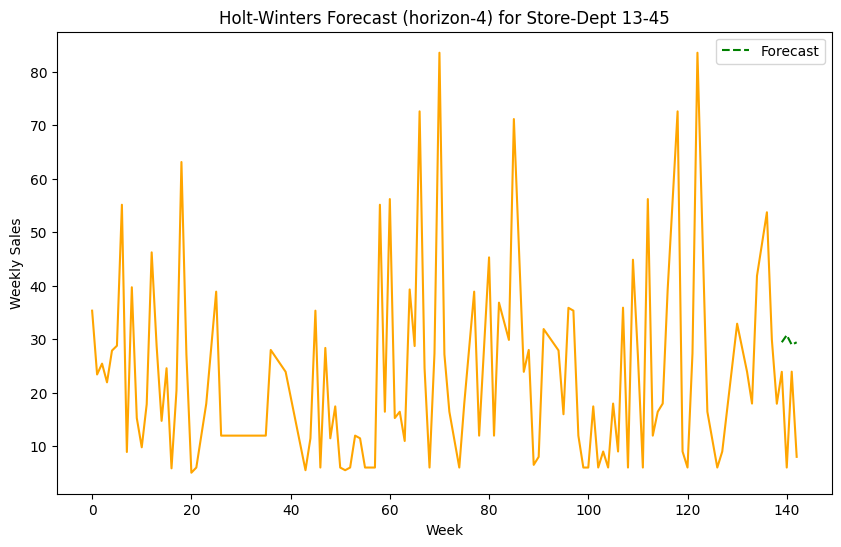

In [13]:
key = '13-45'
series = sales_series_df[key]
tes = HoltWinters(
    alpha=0.1,
    beta=0.01,
    gamma=0.1,
    dampening=1.0,
    season_length=52,
    additive=True
)
fcs = tes.fit_predict(series.values[:-4], h=4)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)), series.values, color='orange')
plt.plot(range(len(series)-4,len(series)), fcs, label='Forecast', color='green', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast (horizon-4) for Store-Dept {key}')
plt.legend()
plt.show()

# Method 1: Per item forecasting

## Forecasting and parameters optimization

In [14]:
def forecast(series, h, alpha, beta, gamma,additive=False):
    model = HoltWinters(
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        dampening=1.0,
        season_length=52,
        additive=additive
    )
    """Forecasts the given time series with horizon-1 for the last h points of the data using the Holt-Winters method."""
    fcs = np.zeros(h)
    for horizon in range(1,h+1):
        fcs[horizon-1] = model.fit_predict(series.values[:-(h+1-horizon)], h=1)[0]
    return fcs

### Horizon-1 forecasts example

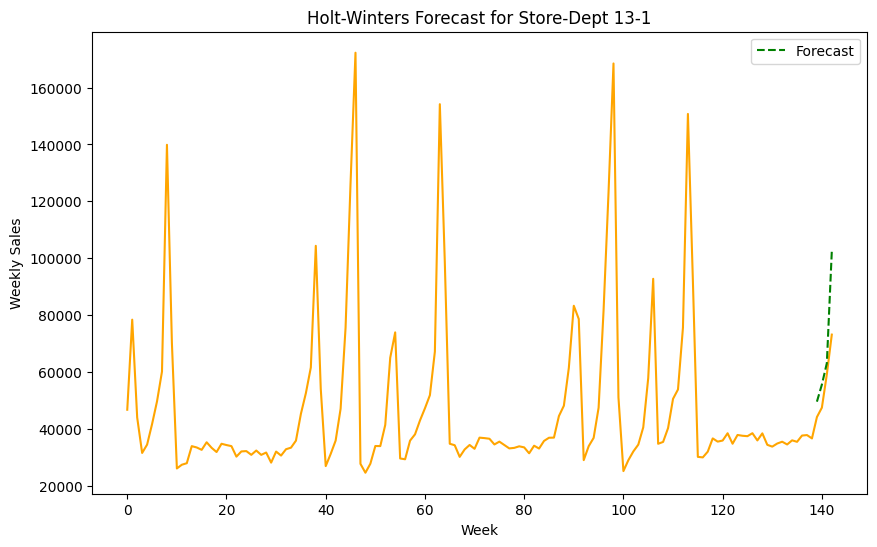

In [15]:
key = '13-1'
series = sales_series_df[key]
h = 4
fcs = forecast(series, h, alpha=0.2, beta=0.1, gamma=0.1)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)), series.values, color='orange')
plt.plot(range(len(series)-4,len(series)), fcs, label='Forecast', color='green', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast for Store-Dept {key}')
plt.legend()
plt.show()

### Grid search example

In [16]:
#KPIs
def mape(real,predicted):
    return np.mean(
        np.abs(
            np.array(real)-np.array(predicted)
            )
        ) / np.sum(real) * 100
def mse(real,predicted):
    return np.mean(
        (np.array(real) - np.array(predicted))**2
    ) / len(real)
def mae(real,predicted):
    return np.mean(
        np.abs(np.array(real)-np.array(predicted))
    ) / len(real)
def rmse(real,predicted):
    return np.sqrt(mse(real,predicted))

In [17]:
def grid_search(series, h, alpha_values, beta_values, gamma_values,additive=False,tqdm_disable=False):
    
    best_params = (None, None, None)
    best_mse = float('inf')
    best_mae = float('inf')
    best_mape = float('inf')
    
    for alpha in tqdm(alpha_values,disable=tqdm_disable):
        for beta in beta_values:
            for gamma in gamma_values:
                fcs = forecast(series, h, alpha, beta, gamma, additive=additive)
                actuals = series.values[-h:]
                cur_mape = mape(actuals,fcs)
                cur_mse = mse(actuals,fcs)
                cur_mae = mae(actuals,fcs)
                if cur_mape < best_mape:
                    best_mape = cur_mape
                    best_mse = cur_mse
                    best_mae = cur_mae
                    best_params = (alpha, beta, gamma)
                    
    return best_params, best_mse,best_mae, best_mape

#### Multiplicative

100%|██████████| 19/19 [00:02<00:00,  6.56it/s]


Best Parameters: alpha=0.15000000000000002, beta=0.15000000000000002, gamma=0.9500000000000001
Best MSE: 1241801.131159699 | Best MAE: 466.66469553334264 | Best mape: 0.83%


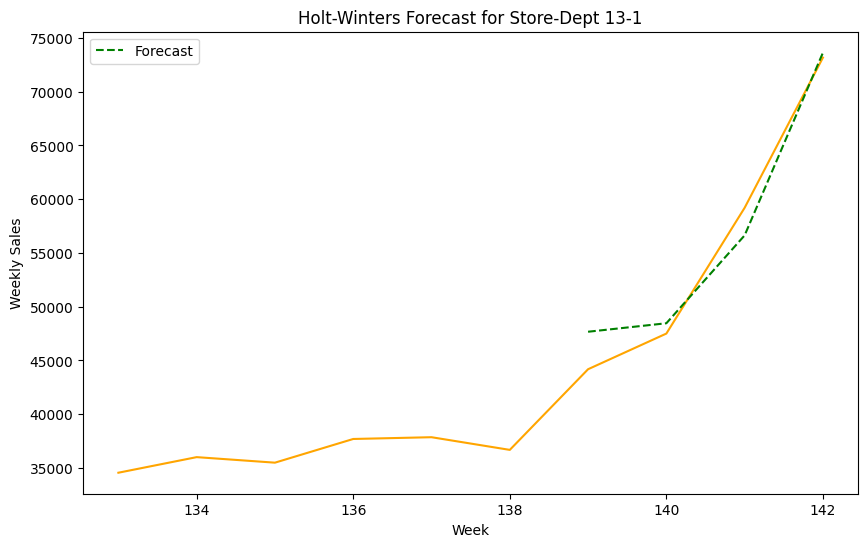

In [18]:
key = '13-1'
series = sales_series_df[key]
h = 4
additive=False
alpha = np.arange(0.05, 1.0, 0.05)
beta = np.arange(0.05, 1.0, 0.05)
gamma = np.arange(0.05, 1.0, 0.05)
params_mult, mse_mult, mae_mult, mape_mult = grid_search(series,h, alpha, beta, gamma, additive=additive)
print(f"Best Parameters: alpha={params_mult[0]}, beta={params_mult[1]}, gamma={params_mult[2]}")
print(f"Best MSE: {mse_mult} | Best MAE: {mae_mult} | Best mape: {mape_mult:0.2f}%")
fcs = forecast(series, h, params_mult[0], params_mult[1], params_mult[2], additive=additive)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)-10,len(series)), series.values[-10:], color='orange')
plt.plot(range(len(series)-4,len(series)), fcs, label='Forecast', color='green', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast for Store-Dept {key}')
plt.legend()
plt.show()

#### Additive

100%|██████████| 19/19 [00:02<00:00,  6.81it/s]


Best Parameters: alpha=0.2, beta=0.35000000000000003, gamma=0.9500000000000001
Best MSE: 247031.83987202228 | Best MAE: 215.97198168072964 | Best MAPE: 0.39%


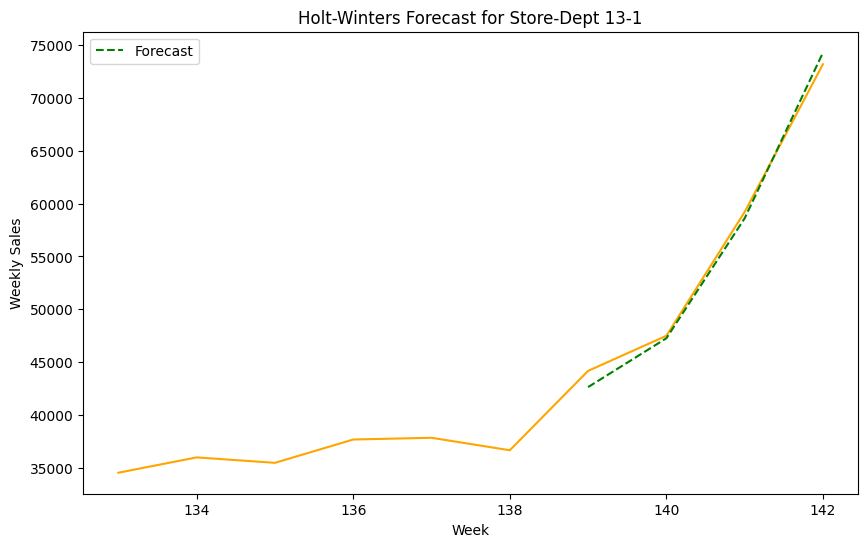

In [19]:
key = '13-1'
series = sales_series_df[key]
h = 4
additive=True
alpha = np.arange(0.05, 1.0, 0.05)
beta = np.arange(0.05, 1.0, 0.05)
gamma = np.arange(0.05, 1.0, 0.05)
params_mult, mse_mult, mae_mult, mape_mult = grid_search(series,h, alpha, beta, gamma, additive=additive)
print(f"Best Parameters: alpha={params_mult[0]}, beta={params_mult[1]}, gamma={params_mult[2]}")
print(f"Best MSE: {mse_mult} | Best MAE: {mae_mult} | Best MAPE: {mape_mult:0.2f}%")
fcs = forecast(series, h, params_mult[0], params_mult[1], params_mult[2], additive=additive)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)-10,len(series)), series.values[-10:], color='orange')
plt.plot(range(len(series)-4,len(series)), fcs, label='Forecast', color='green', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast for Store-Dept {key}')
plt.legend()
plt.show()

In this case (store 13, department 1) we can see that additive TES performs better, however there are some cases where the opposite might be true.

In [20]:
key = '13-23'
series = sales_series_df[key]
h = 4
alpha = np.arange(0.05, 1.0, 0.05)
beta = np.arange(0.05, 1.0, 0.05)
gamma = np.arange(0.05, 1.0, 0.05)
params_additive, mse_additive, mae_additive, mape_additive = grid_search(series,h, alpha, beta, gamma, additive=True)
print(f"Best Parameters for additive: alpha={params_additive[0]:0.2f}, beta={params_additive[1]:0.2f}, gamma={params_additive[2]:0.2f}")
print(f"Best MSE: {mse_additive} | Best MAE: {mae_additive} | Best MAPE: {mape_additive:0.2f}%")
params_mult, mse_mult, mae_mult, mape_mult = grid_search(series,h, alpha, beta, gamma, additive=False)
print(f"Best Parameters for multiplicative: alpha={params_mult[0]:0.2f}, beta={params_mult[1]:0.2f}, gamma={params_mult[2]:0.2f}")
print(f"Best MSE: {mse_mult} | Best MAE: {mae_mult} | Best MAPE: {mape_mult:0.2f}%")

100%|██████████| 19/19 [00:02<00:00,  6.65it/s]


Best Parameters for additive: alpha=0.05, beta=0.15, gamma=0.95
Best MSE: 2385058.4792812355 | Best MAE: 582.5137964605435 | Best MAPE: 1.84%


100%|██████████| 19/19 [00:02<00:00,  7.04it/s]

Best Parameters for multiplicative: alpha=0.10, beta=0.55, gamma=0.25
Best MSE: 100116.2919377361 | Best MAE: 125.93638734212254 | Best MAPE: 0.40%


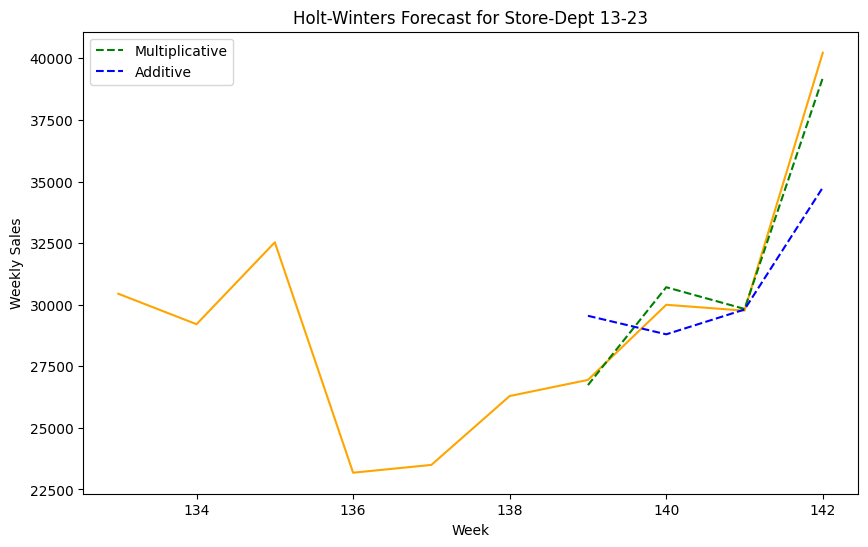

In [21]:
fcs_mult= forecast(series, h, params_mult[0], params_mult[1], params_mult[2], additive=False)
fcs_add= forecast(series, h, params_additive[0], params_additive[1], params_additive[2], additive=True)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)-10,len(series)), series.values[-10:], color='orange')
plt.plot(range(len(series)-4,len(series)), fcs_mult, label='Multiplicative', color='green', linestyle='--')
plt.plot(range(len(series)-4,len(series)), fcs_add, label='Additive', color='blue', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast for Store-Dept {key}')
plt.legend()
plt.show()

## Finding best parameter per store-department combination

In [22]:
alphas = dict()
betas = dict()
gammas = dict()
mses = dict()
maes = dict()
mapes = dict()
additives = dict()
# for key in tqdm(['13-1','13-23','13-33','13-35','13-13']):
for key in tqdm(sales_series_df.columns):
    series = sales_series_df[key]
    h = 4
    alpha = np.arange(0.05, 1.0, 0.05)
    beta = np.arange(0.05, 1.0, 0.05)
    gamma = np.arange(0.05, 1.0, 0.05)
    params_mult, mse_mult, mae_mult, mape_mult = grid_search(series,h, alpha, beta, gamma, additive=False,tqdm_disable=True)
    params_add, mse_add, mae_add, mape_add = grid_search(series,h, alpha, beta, gamma, additive=True,tqdm_disable=True)
    if mape_mult < mape_add:
        alphas[key] = params_mult[0]
        betas[key] = params_mult[1]
        gammas[key] = params_mult[2]
        mses[key] = mse_mult
        maes[key] = mae_mult
        mapes[key] = mape_mult
        additives[key] = False
    else:
        alphas[key] = params_add[0]
        betas[key] = params_add[1]
        gammas[key] = params_add[2]
        mses[key] = mse_add
        maes[key] = mae_add
        mapes[key] = mape_add
        additives[key] = True
        
best_params_df = pd.DataFrame({
    'dept': {key: key.split('-')[1] for key in sales_series_df.columns},
    'alpha': alphas,
    'beta': betas,
    'gamma': gammas,
    'mse': mses,
    'mae': maes,
    'mape': mapes,
    'additive': additives
    })
#save for later use
best_params_df.reset_index().drop(columns=['index']).to_csv("holt_winters_best_params.csv",index=False)

100%|██████████| 74/74 [05:29<00:00,  4.45s/it]


instead of running every time, we can load already saved dataframe

In [23]:
best_params_df = pd.read_csv("holt_winters_best_params.csv")
best_params_df.sort_values(by='mape',ascending=False)

,dept,alpha,beta,gamma,mse,mae,mape,additive
41,45,0.05,0.65,0.25,2.424640e+01,1.882277,12.196841,True
52,59,0.05,0.05,0.25,4.356582e+03,23.161038,6.779469,True
48,54,0.05,0.25,0.05,4.049111e+01,2.361378,6.608027,True
29,31,0.05,0.15,0.10,3.901346e+05,212.133911,4.753903,False
23,25,0.05,0.15,0.05,4.655336e+06,707.885685,3.970879,False
...,...,...,...,...,...,...,...,...
65,90,0.05,0.40,0.20,1.987784e+05,205.056527,0.158020,True
1,2,0.30,0.40,0.70,5.779202e+04,86.250598,0.113860,True
70,95,0.20,0.25,0.55,1.533774e+05,148.197205,0.109457,False
60,81,0.05,0.05,0.25,7.818584e+03,32.377340,0.096811,True


# Method 2: Aggregated data forecasting

## Aggregating by store

We will add all departments within one store and forecast on the aggregated data. This will yield a single prediction for the sales of the whole store, which we would need to de-aggregated afterwards to get predictions for each department within. In order to do this we will keep weights for each department's contribution.

In [24]:
# adding all departments into a single timeseries
agg_data = sales_series_df.sum(axis=1).rename('sales')

Visualizing the aggregated data

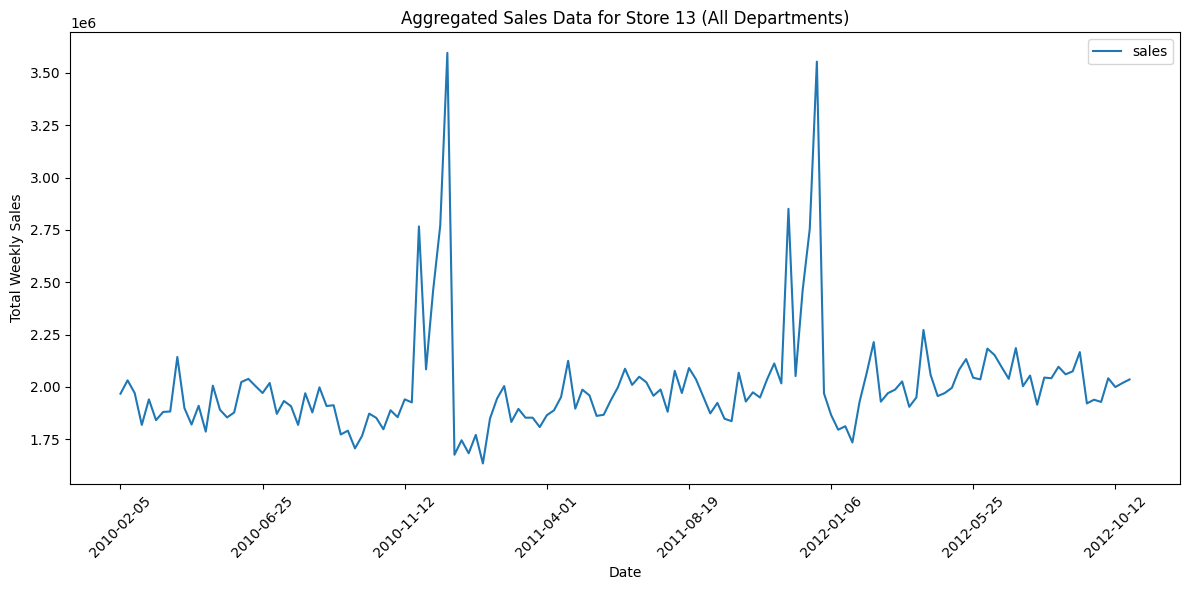

In [25]:
agg_data.plot(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.title('Aggregated Sales Data for Store 13 (All Departments)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Using grid search to find the best model parameters

In [26]:
h = 4
alpha = np.arange(0.05, 1.0, 0.05)
beta = np.arange(0.05, 1.0, 0.05)
gamma = np.arange(0.05, 1.0, 0.05)
params_additive, mse_additive, mae_additive, mape_additive = grid_search(agg_data,h, alpha, beta, gamma, additive=True)
params_mult, mse_mult, mae_mult, mape_mult = grid_search(agg_data,h, alpha, beta, gamma, additive=False)

100%|██████████| 19/19 [00:02<00:00,  6.48it/s]


In [27]:
print(f"Best Parameters for additive: alpha={params_additive[0]:0.2f}, beta={params_additive[1]:0.2f}, gamma={params_additive[2]:0.2f}")
print(f"Best MSE: {mse_additive} | Best MAE: {mae_additive} | Best MAPE: {mape_additive:0.2f}%")
print(f"Best Parameters for multiplicative: alpha={params_mult[0]:0.2f}, beta={params_mult[1]:0.2f}, gamma={params_mult[2]:0.2f}")
print(f"Best MSE: {mse_mult} | Best MAE: {mae_mult} | Best MAPE: {mape_mult:0.2f}%")

Best Parameters for additive: alpha=0.10, beta=0.05, gamma=0.20
Best MSE: 30399340.91904807 | Best MAE: 2346.187212202436 | Best MAPE: 0.12%
Best Parameters for multiplicative: alpha=0.20, beta=0.25, gamma=0.75
Best MSE: 148213852.54756805 | Best MAE: 4468.783444833185 | Best MAPE: 0.22%


Additive TES performs better on the aggregated data so we will use it for comparison with per-item forecasts.

# Comparison between unit-level and aggregated forecasting

In [28]:
# calculating forecasts for all departments based on best parameters found earlier
unit_fcs = dict()
for dept in tqdm(departments_to_use):
    series = sales_series_df[f'13-{dept}']
    unit_fcs[f'13-{dept}'] = forecast(series, 4, best_params_df.loc[best_params_df['dept']==dept, 'alpha'].values[0],
                        best_params_df.loc[best_params_df['dept']==dept, 'beta'].values[0],
                        best_params_df.loc[best_params_df['dept']==dept, 'gamma'].values[0],
                        additive=best_params_df.loc[best_params_df['dept']==dept, 'additive'].values[0]
                        )

100%|██████████| 74/74 [00:00<00:00, 908.12it/s]


In [29]:
#static department weights calculation
static_weights = sales_series_df.sum() / sales_series_df.sum().sum()

In [30]:
def calculate_dynamic_weights(df):
    agg_data = df.sum(axis=1).rename('sales')
    weights_dict = {}
    for dept in departments_to_use:
        weights_df = (df[f"13-{dept}"] / agg_data).rename('weight')
        weights_df = pd.DataFrame(weights_df)
        weights_df['week'] = pd.to_datetime(weights_df.index).isocalendar().week.astype(int)
        weights_df = weights_df.groupby('week')['weight'].mean()
        weights_dict.update({(int(dept),week): weight for week,weight in weights_df.items()})
    return weights_dict
    
dynamic_weights = calculate_dynamic_weights(sales_series_df) 

In [31]:
def deaggregate_forecasts(agg_fcs,dynamic_weights,static_weights=static_weights):
    
    last_date = pd.to_datetime('2012-09-28') 
    forecast_dates = pd.date_range(last_date + pd.Timedelta(weeks=1), periods=4, freq='W-FRI')

    forecast_weeks = forecast_dates.isocalendar().week.astype(int).tolist()

    deagg_fcs = {}

    for dept in departments_to_use:
        dept_weights = []
        
        for wk in forecast_weeks:
            w = dynamic_weights[(dept, wk)]   
            dept_weights.append(w)
        
        dept_weights = np.array(dept_weights)
        
        deagg_fcs[f"13-{int(dept)}"] = agg_fcs * dept_weights
    return deagg_fcs

In [32]:
# deaggregating forecasts
agg_fcs = forecast(agg_data,h=4,alpha=0.1,beta=0.05,gamma=0.2,additive=True)
# deaggregating using only static weights
# agg_fcs = {
#     dept : agg_fcs * static_weights[dept] for dept in departments_to_use
# }
agg_fcs = deaggregate_forecasts(agg_fcs,dynamic_weights)
# combining into a dataframe for easier use
real_values = {dept: sales_series_df.iloc[-4:][dept].values.tolist() for dept in sales_series_df.columns}
results_df =pd.DataFrame({
    "unit" : unit_fcs,
    "agg" : agg_fcs,
    "real" : real_values
})

Important to note, here we are using `dynamic` department weights, i.e. a different weight for each (deapartment,week) tuple, instead of a single `static` weight for the whole department. The motivation behind this is that when using a single weight for the whole timeseries we lose the temporal information that different department might have different seasonal peaks at different time periods. This leads to far worse performance, compared to per-week weights. Although not shown below, The code can be swaped to only use static weights, which would show vastly worse performance for the aggregated forecasts.

In [33]:
metrics_df = pd.DataFrame({
    'dept': results_df.index,
    'unit_mape': [mape(results_df.loc[dept, 'real'], results_df.loc[dept, 'unit']) for dept in results_df.index],
    'unit_rmse': [rmse(results_df.loc[dept, 'real'], results_df.loc[dept, 'unit']) for dept in results_df.index],
    'agg_mape': [mape(results_df.loc[dept, 'real'], results_df.loc[dept, 'agg']) for dept in results_df.index],
    'agg_rmse': [rmse(results_df.loc[dept, 'real'], results_df.loc[dept, 'agg']) for dept in results_df.index]
})
metrics_df.sort_values(by='unit_mape',ascending=False)

,dept,unit_mape,unit_rmse,agg_mape,agg_rmse
41,13-45,12.196841,4.924063,12.070020,4.490271
52,13-59,6.779469,66.004411,21.005685,152.702806
48,13-54,6.608027,6.363263,28.868059,22.955114
29,13-31,4.753903,624.607529,6.138224,613.825113
23,13-25,3.970879,2157.622753,4.062360,1883.415562
...,...,...,...,...,...
65,13-90,0.158020,445.845678,0.454705,1212.822828
1,13-2,0.113860,240.399703,0.322103,564.805496
70,13-95,0.109457,391.634310,0.184522,573.073882
60,13-81,0.096811,88.422757,0.469419,325.889422


We'll be looking mainly at MAPE KPI, because a lot of the different departments have vastly different domains (some are bounded below 1000, while others can reach values in the 50 000s). First let's look at the distribution of errors in both forecasting methods.

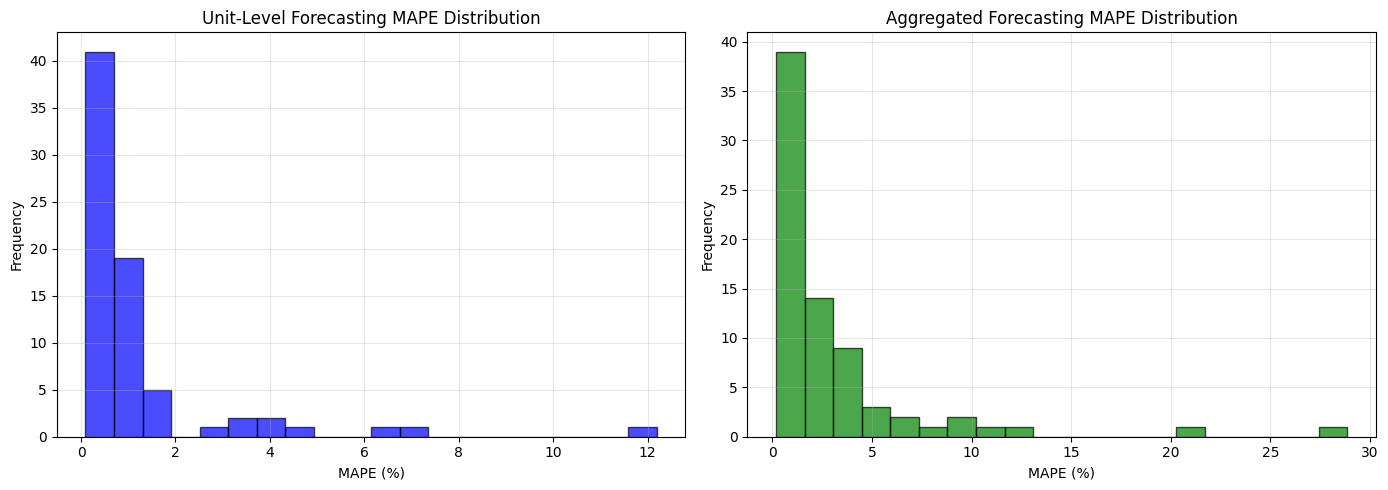

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram for unit_mape
axes[0].hist(metrics_df['unit_mape'], bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_xlabel('MAPE (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Unit-Level Forecasting MAPE Distribution')
axes[0].grid(alpha=0.3)

# Histogram for agg_mape
axes[1].hist(metrics_df['agg_mape'], bins=20, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlabel('MAPE (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Aggregated Forecasting MAPE Distribution')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

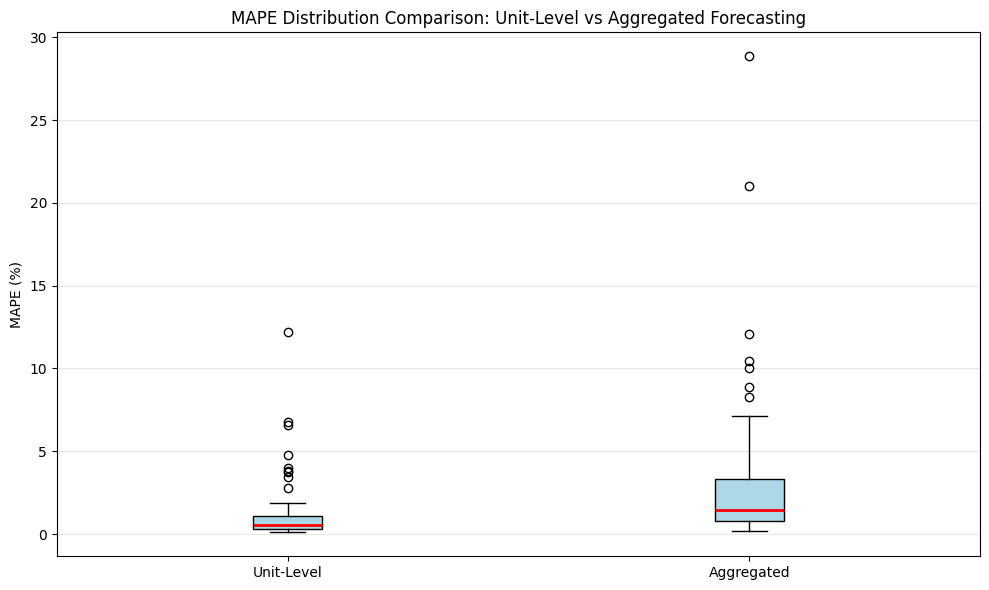

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.boxplot([metrics_df['unit_mape'], metrics_df['agg_mape']], 
           tick_labels=['Unit-Level', 'Aggregated'],
           patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='red', linewidth=2))

ax.set_ylabel('MAPE (%)')
ax.set_title('MAPE Distribution Comparison: Unit-Level vs Aggregated Forecasting')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


We can see that for the aggregated forecasting, the errors are more spread out, even reaching above 20% for 2 departments. On the other hand, unit-level prediction reach far more consistent error , only having a single outlier above 10%. Lets look at the top 5 and worst 5 for both methods and compare the results of both for those particular departments.

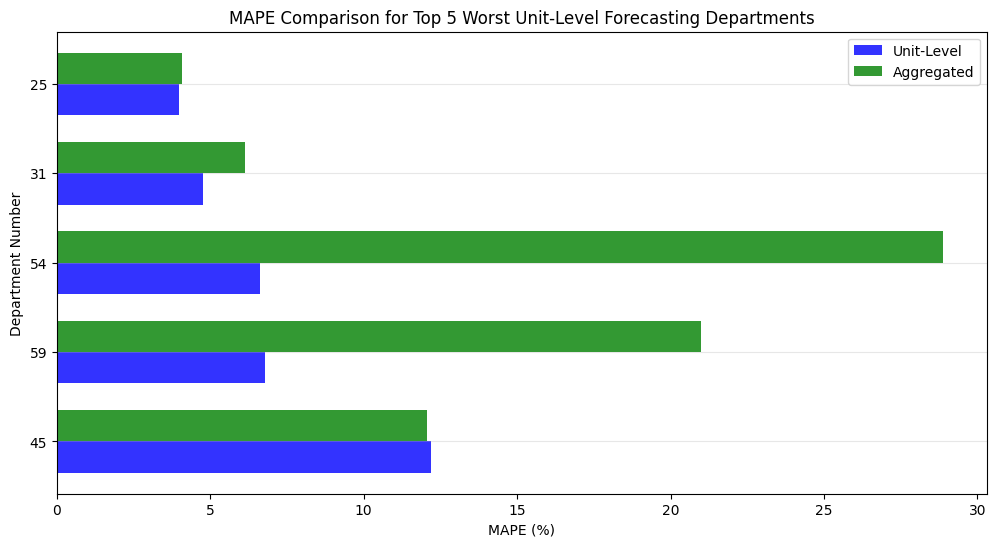

In [36]:
top_5_unit = metrics_df.sort_values(by='unit_mape', ascending=False).head(5)
top_5_agg = metrics_df.sort_values(by='agg_mape', ascending=False).head(5)
bot_5_unit = metrics_df.sort_values(by='unit_mape', ascending=True).head(5)
bot_5_agg = metrics_df.sort_values(by='agg_mape', ascending=True).head(5)

# Create bar plot comparing MAPE for top 5 worst unit-level departments
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(top_5_unit))
width = 0.35

# Extract department numbers for labels
dept_labels = [dept.split('-')[1] for dept in top_5_unit['dept']]

bars1 = ax.barh(x - width/2, top_5_unit['unit_mape'], width, label='Unit-Level', alpha=0.8, color='blue')
bars2 = ax.barh(x + width/2, top_5_unit['agg_mape'], width, label='Aggregated', alpha=0.8, color='green')

ax.set_ylabel('Department Number')
ax.set_xlabel('MAPE (%)')
ax.set_title('MAPE Comparison for Top 5 Worst Unit-Level Forecasting Departments')
ax.set_yticks(x)
ax.set_yticklabels(dept_labels)
ax.legend()
ax.grid(alpha=0.3, axis='y')



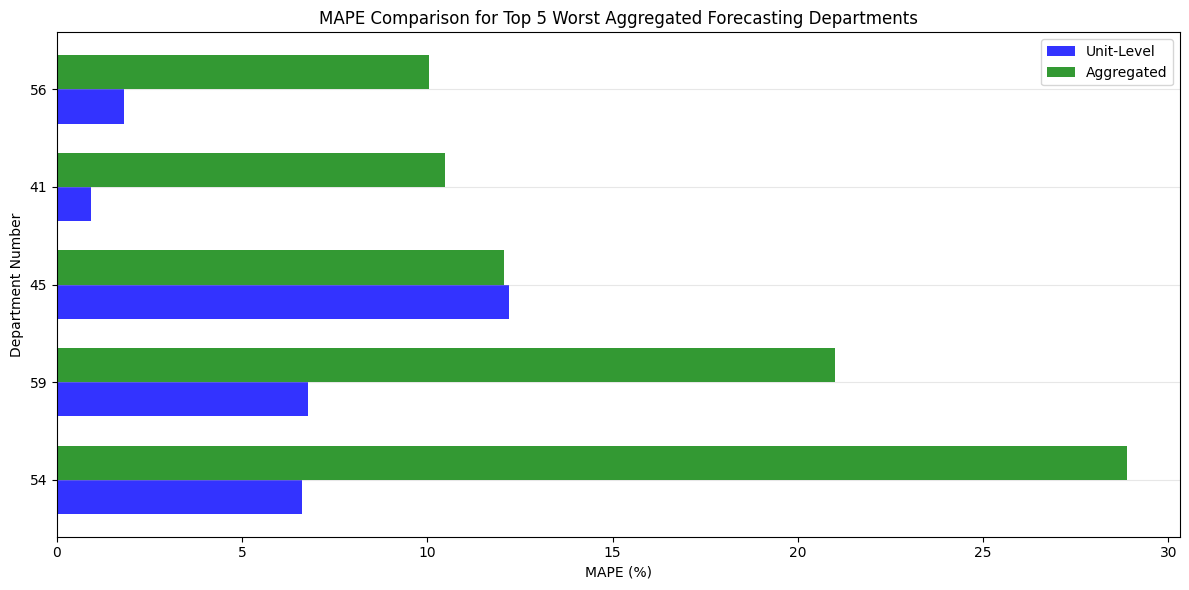

In [37]:
# Similarly for top 5 worst aggregated departments
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(top_5_agg))
dept_labels_agg = [dept.split('-')[1] for dept in top_5_agg['dept']]

bars1 = ax.barh(x - width/2, top_5_agg['unit_mape'], width, label='Unit-Level', alpha=0.8, color='blue')
bars2 = ax.barh(x + width/2, top_5_agg['agg_mape'], width, label='Aggregated', alpha=0.8, color='green')

ax.set_ylabel('Department Number')
ax.set_xlabel('MAPE (%)')
ax.set_title('MAPE Comparison for Top 5 Worst Aggregated Forecasting Departments')
ax.set_yticks(x)
ax.set_yticklabels(dept_labels_agg)
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

We notice that departments 45, 54 and 59 are amongst the worst for both methods.

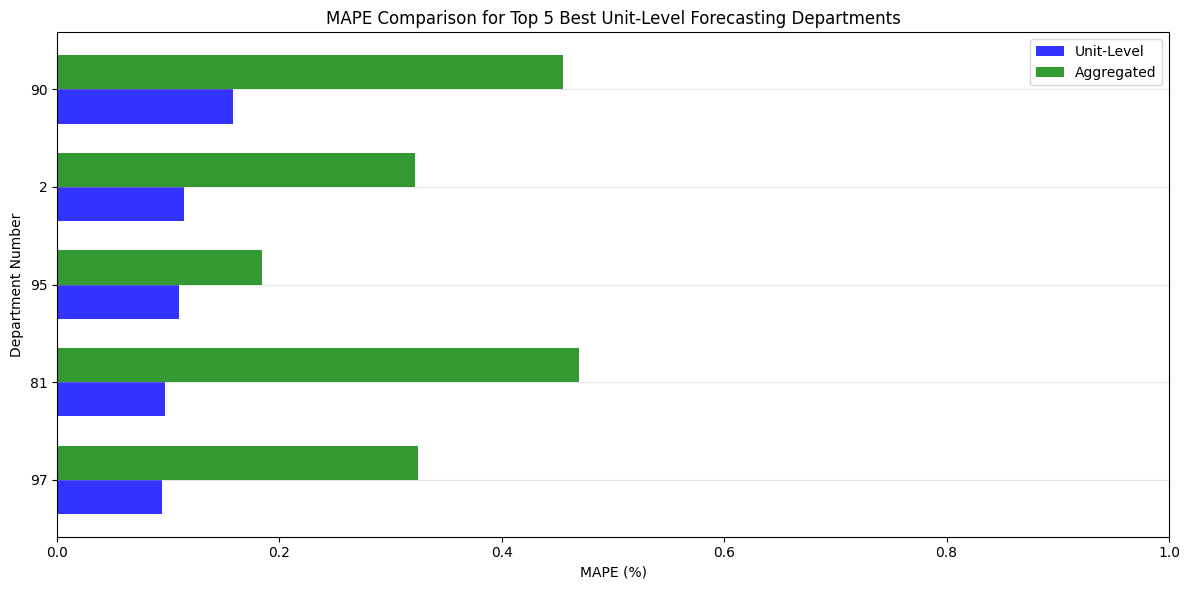

In [38]:
# Best 5 departments for unit-level
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(bot_5_unit))
dept_labels_bot_unit = [dept.split('-')[1] for dept in bot_5_unit['dept']]

bars1 = ax.barh(x - width/2, bot_5_unit['unit_mape'], width, label='Unit-Level', alpha=0.8, color='blue')
bars2 = ax.barh(x + width/2, bot_5_unit['agg_mape'], width, label='Aggregated', alpha=0.8, color='green')

ax.set_ylabel('Department Number')
ax.set_xlabel('MAPE (%)')
ax.set_title('MAPE Comparison for Top 5 Best Unit-Level Forecasting Departments')
ax.set_yticks(x)
ax.set_yticklabels(dept_labels_bot_unit)
ax.legend()
ax.set_xlim(0,1)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

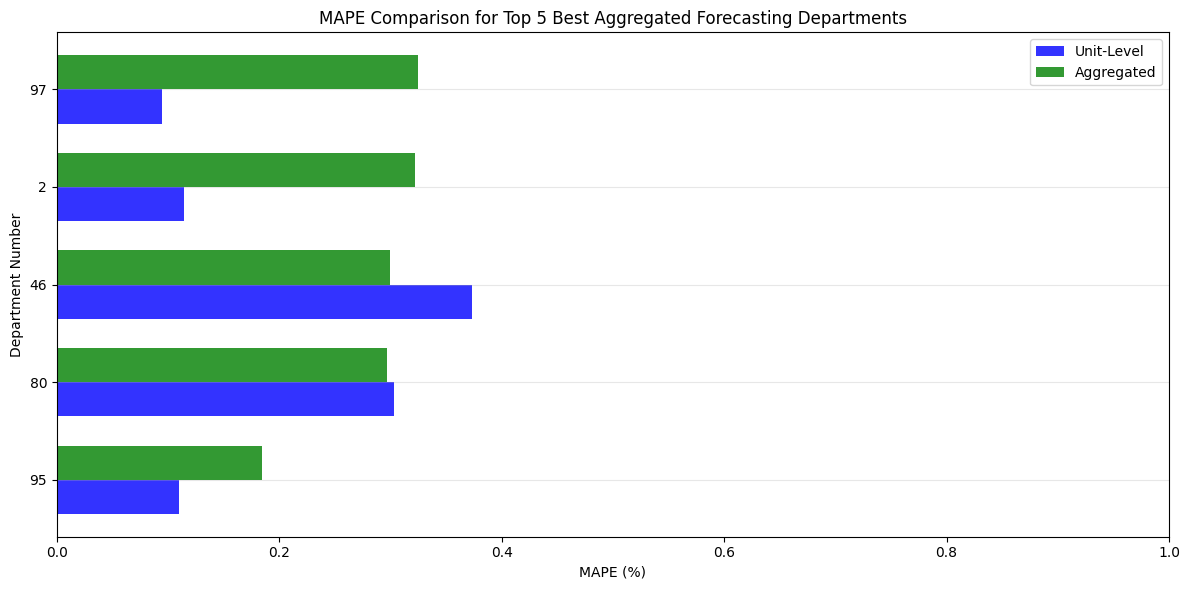

In [39]:
# Best 5 departments for aggregated
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(bot_5_agg))
dept_labels_bot_agg = [dept.split('-')[1] for dept in bot_5_agg['dept']]

bars1 = ax.barh(x - width/2, bot_5_agg['unit_mape'], width, label='Unit-Level', alpha=0.8, color='blue')
bars2 = ax.barh(x + width/2, bot_5_agg['agg_mape'], width, label='Aggregated', alpha=0.8, color='green')

ax.set_ylabel('Department Number')
ax.set_xlabel('MAPE (%)')
ax.set_title('MAPE Comparison for Top 5 Best Aggregated Forecasting Departments')
ax.set_yticks(x)
ax.set_yticklabels(dept_labels_bot_agg)

ax.legend()
ax.set_xlim(0,1)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Amongst the best forecasted departments, only the 2, 95 and 97 department is common. We also notice that the best for aggregated performance are still worse than compared to their unit-level counterparts, with exception for departments 46 and 80.

In [40]:
metrics_df['performance_ratio'] = metrics_df['agg_mape'] - metrics_df['unit_mape']
metrics_df['performance_ratio'].describe()

count    74.000000
mean      1.818043
std       3.424723
min      -0.550603
25%       0.213534
50%       0.735064
75%       2.146988
max      22.260032
Name: performance_ratio, dtype: float64

In [41]:
metrics_df.sort_values(by='performance_ratio',ascending=False).head(1)

,dept,unit_mape,unit_rmse,agg_mape,agg_rmse,performance_ratio
48,13-54,6.608027,6.363263,28.868059,22.955114,22.260032


We can see that store-level forecasting is on average 1.8% higher, with 50% of departments having an 0.7% higher error. The worst case is for department 54, where the error is 22% higher. This leads us to think that aggregating in this case leads to worse resolution of the forecast, relative to the MAPE KPI. A likely explanation might be that if for some stores, the sales are vastly lower than others, and they have different peaks, i.e. one has a peak around spring and the other around end of year, the bigger department's sales might overshadow the smaller one and lead to vastly worse forecasting power.  
In order to avoid this issue, it is possible to only aggregated common departments and forecast per group, instead of in one single timeseries for the whole store.

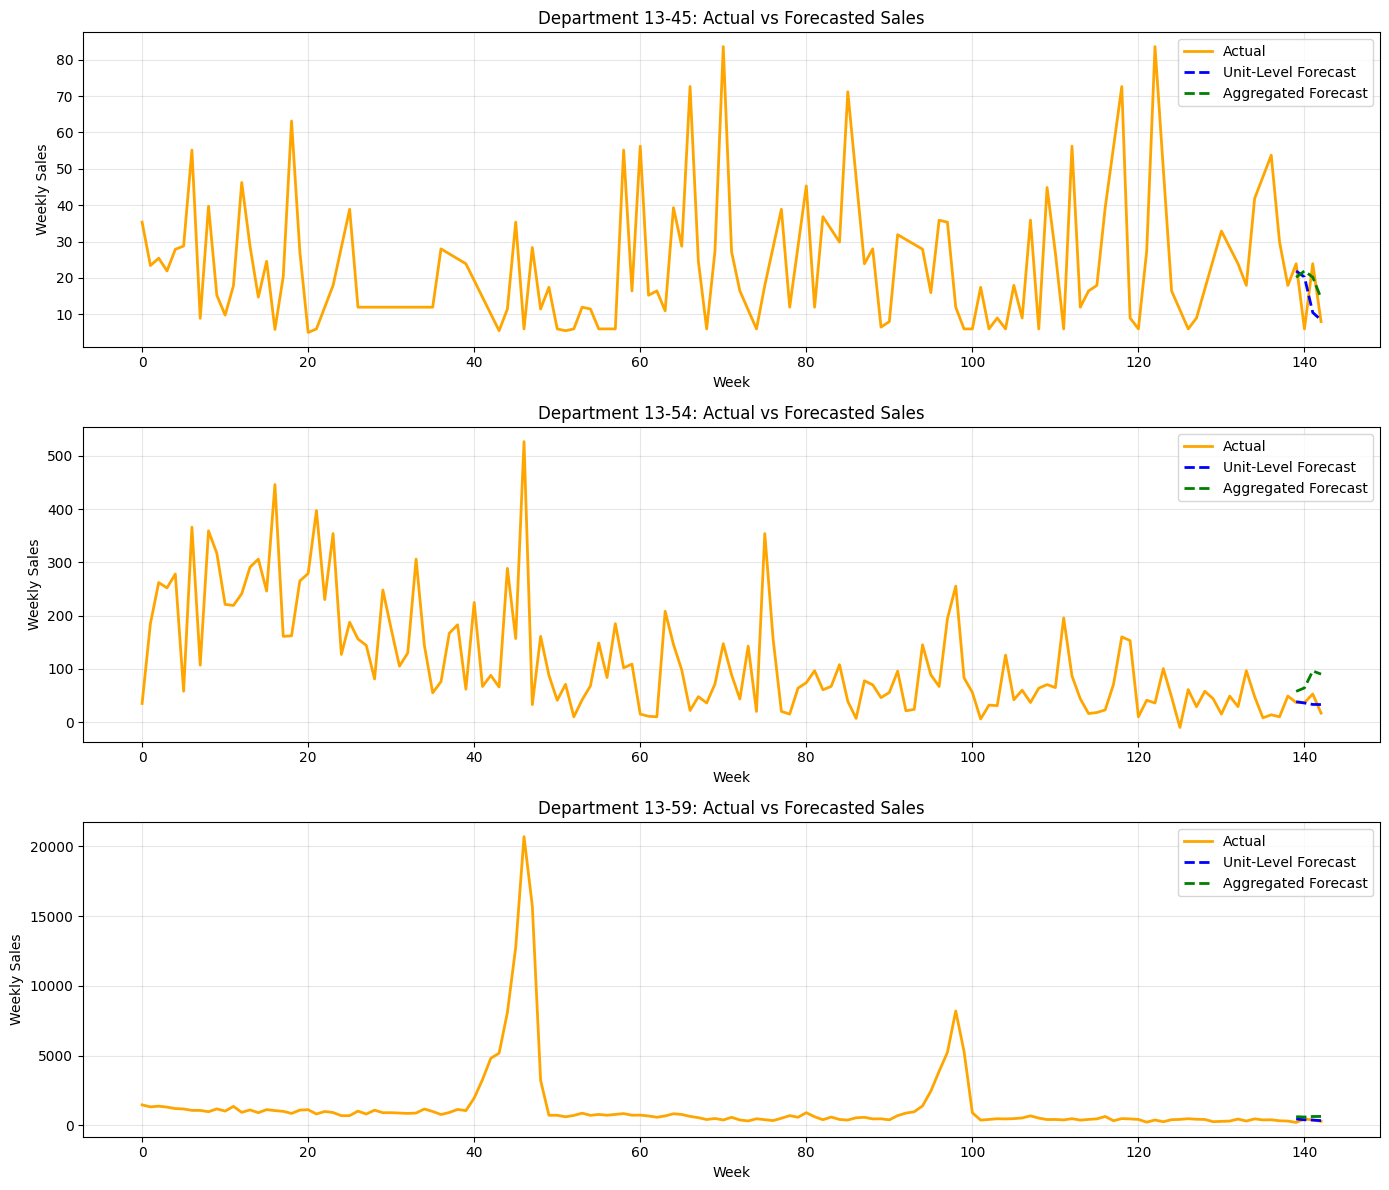

In [42]:
# Plot departments 45, 54 and 59 to visualize their time series
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Department 45
dept_45 = sales_series_df['13-45']
axes[0].plot(range(0, len(dept_45)), dept_45.values, color='orange', linewidth=2, label='Actual')
axes[0].plot(range(len(dept_45)-4, len(dept_45)), results_df.loc['13-45', 'unit'], color='blue', linestyle='--', linewidth=2, label='Unit-Level Forecast')
axes[0].plot(range(len(dept_45)-4, len(dept_45)), results_df.loc['13-45', 'agg'], color='green', linestyle='--', linewidth=2, label='Aggregated Forecast')
axes[0].set_xlabel('Week')
axes[0].set_ylabel('Weekly Sales')
axes[0].set_title('Department 13-45: Actual vs Forecasted Sales')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Department 54
dept_54 = sales_series_df['13-54']
axes[1].plot(range(0, len(dept_54)), dept_54.values, color='orange', linewidth=2, label='Actual')
axes[1].plot(range(len(dept_54)-4, len(dept_54)), results_df.loc['13-54', 'unit'], color='blue', linestyle='--', linewidth=2, label='Unit-Level Forecast')
axes[1].plot(range(len(dept_54)-4, len(dept_54)), results_df.loc['13-54', 'agg'], color='green', linestyle='--', linewidth=2, label='Aggregated Forecast')
axes[1].set_xlabel('Week')
axes[1].set_ylabel('Weekly Sales')
axes[1].set_title('Department 13-54: Actual vs Forecasted Sales')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Department 59
dept_59 = sales_series_df['13-59']
axes[2].plot(range(0, len(dept_59)), dept_59.values, color='orange', linewidth=2, label='Actual')
axes[2].plot(range(len(dept_59)-4, len(dept_59)), results_df.loc['13-59', 'unit'], color='blue', linestyle='--', linewidth=2, label='Unit-Level Forecast')
axes[2].plot(range(len(dept_59)-4, len(dept_59)), results_df.loc['13-59', 'agg'], color='green', linestyle='--', linewidth=2, label='Aggregated Forecast')
axes[2].set_xlabel('Week')
axes[2].set_ylabel('Weekly Sales')
axes[2].set_title('Department 13-59: Actual vs Forecasted Sales')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

- The plots for the worst departments back up our hypothesis, with departments 54 and 59 having lower sales (less than 100 and less than 1000, respectively) and likely being overshadowed by other more active departments, leading to the increase in errors for the aggregated forecast.
- The poor performance of the unit-level forecast, relative to other unit level forecasts, in the case of dept 54 is due to the high volatility in sales of that department, leading to poor forecasting performance.

## Conclusions
Unit-level forecasting is overall performing better, with a few outliers. Aggregating the data into a single timeseries can be helpful for overall insides in the total store performance, but is at the cost of losing information fidelity for eachdepartment. A possible improvement to the process is to normalize the timeseries data before aggregating, which would remove the problem of certain departments overshadowing the rest in the aggregated timeseries. However, the problem of mismatched seasonalities for department will still be present. For example, 'swimwear' might peak during the end of spring and beggining of summer, while 'sweaters' might peak at the end of autumn and beggining of winter. Aggregating the two timeseries together would create a new dataset with 2 seasonalities, which would increase the complexity of the data, and likely lead to lower forecasting performance. In order to account for this issue, it is possible to only aggregate departments in similar groups, such that all the departments within a single group peak around the same time, reducing the unnecessary complexity induced by aggregating.

# TODO!: Part II - contract forecasting

Use the same store 13 aggregated data. 

In [48]:
contract_df = pd.DataFrame(sales_data[sales_data['Store']==13].groupby('Date')['Weekly_Sales'].sum())
contract_df

,Weekly_Sales
Date,
2010-02-05,1967220.53
2010-02-12,2030933.46
2010-02-19,1970274.64
2010-02-26,1817850.32
2010-03-05,1939980.43
...,...
2012-09-28,1927664.11
2012-10-05,2041918.74
2012-10-12,1999079.44
